In [1]:

from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier,VotingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.naive_bayes import GaussianNB,MultinomialNB,BernoulliNB
from sklearn.model_selection import GridSearchCV, train_test_split, cross_val_score
from sklearn import metrics
from sklearn.preprocessing import StandardScaler, LabelEncoder, OrdinalEncoder, OneHotEncoder
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import time
import pickle

In [2]:
df = pd.read_csv(r'C:\Users\91809\Downloads\Data Science\Python\Python\session-7\train_LZdllcl.csv')

In [3]:
df.head(5)

,employee_id,department,region,education,gender,recruitment_channel,no_of_trainings,age,previous_year_rating,length_of_service,KPIs_met >80%,awards_won?,avg_training_score,is_promoted
0,65438,Sales & Marketing,region_7,Master's & above,f,sourcing,1,35,5.0,8,1,0,49,0
1,65141,Operations,region_22,Bachelor's,m,other,1,30,5.0,4,0,0,60,0
2,7513,Sales & Marketing,region_19,Bachelor's,m,sourcing,1,34,3.0,7,0,0,50,0
3,2542,Sales & Marketing,region_23,Bachelor's,m,other,2,39,1.0,10,0,0,50,0
4,48945,Technology,region_26,Bachelor's,m,other,1,45,3.0,2,0,0,73,0


In [4]:
#dropping unwanted features
df.drop(columns=["employee_id","region","education","department","recruitment_channel"],inplace=True)

KeyError: "['employee_id', 'region', 'education', 'department', 'recruitment_channel'] not found in axis"

In [178]:
#checking % of null values
(df.isnull().mean()*100).sort_values(ascending=False)

previous_year_rating    7.524449
gender                  0.000000
no_of_trainings         0.000000
age                     0.000000
length_of_service       0.000000
KPIs_met >80%           0.000000
awards_won?             0.000000
avg_training_score      0.000000
is_promoted             0.000000
dtype: float64

In [179]:
#sum of null values
(df.isnull().sum()).sort_values(ascending=False)

previous_year_rating    4124
gender                     0
no_of_trainings            0
age                        0
length_of_service          0
KPIs_met >80%              0
awards_won?                0
avg_training_score         0
is_promoted                0
dtype: int64

In [180]:
#All persons whose Previous year rating is null are probably freshers or 
#laterals who haven't completed the minimum evaluation cycle time
#we will consider their score to be the median of overall rating
df[df["previous_year_rating"].isnull()==True]["length_of_service"].value_counts()

1    4124
Name: length_of_service, dtype: int64

In [5]:
#imputation by median
df.loc[df["previous_year_rating"].isnull()==True,"previous_year_rating"] = df["previous_year_rating"].fillna(df["previous_year_rating"].median())

In [182]:
#Null values are treated
(df.isnull().sum()).sort_values(ascending=False)

gender                  0
no_of_trainings         0
age                     0
previous_year_rating    0
length_of_service       0
KPIs_met >80%           0
awards_won?             0
avg_training_score      0
is_promoted             0
dtype: int64

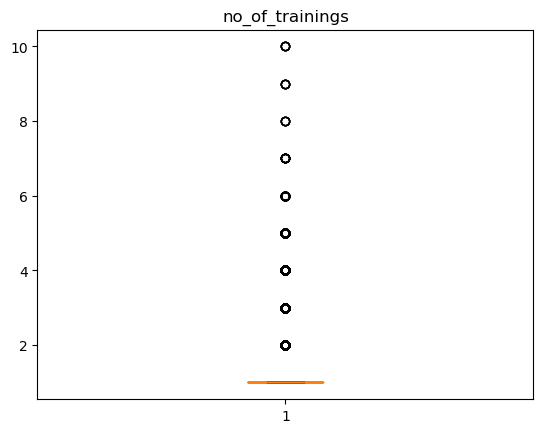

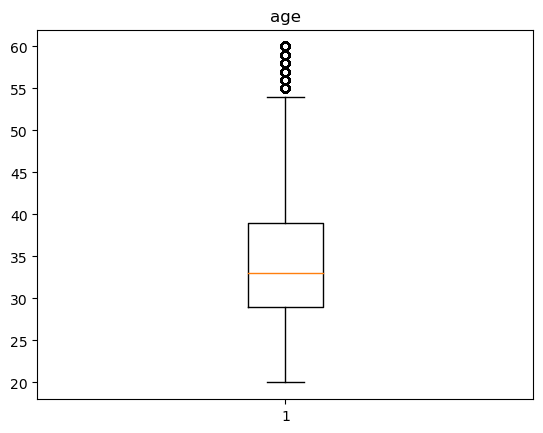

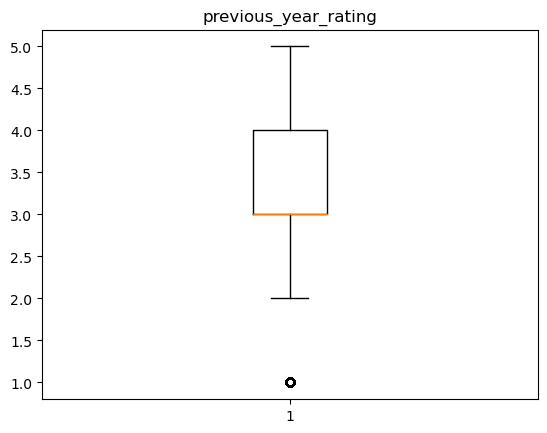

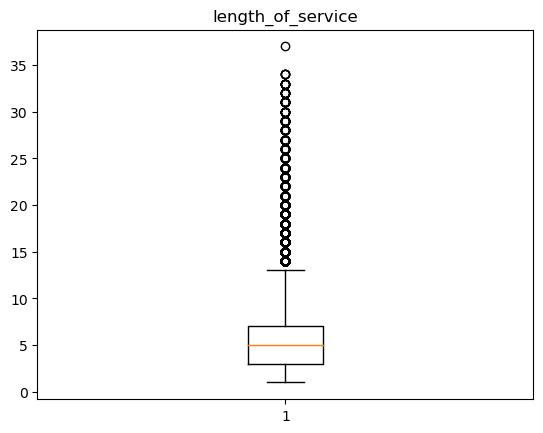

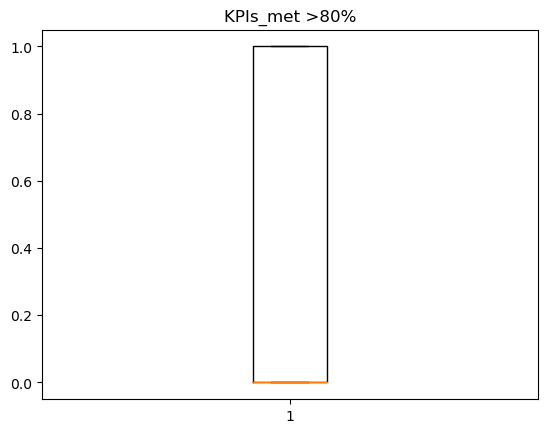

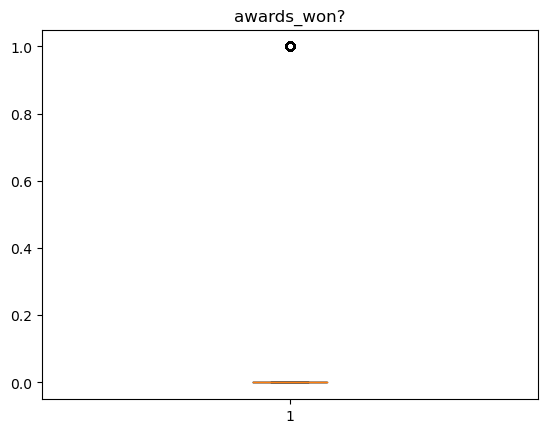

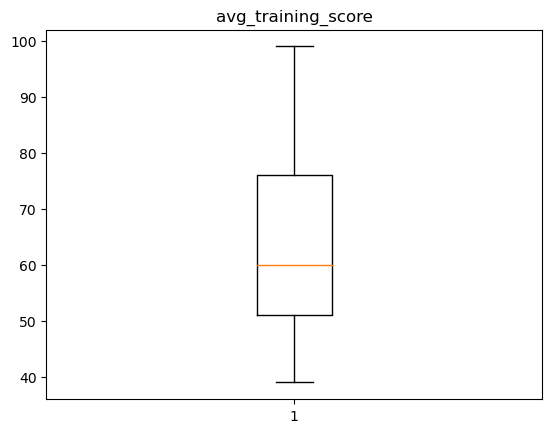

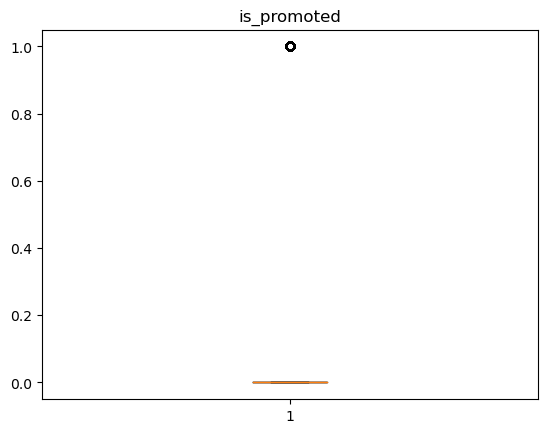

In [60]:
#finding outliers
for i in df.columns:
    if df[i].dtypes != "object":
        plt.title(str(i))
        plt.boxplot(df[i])
        plt.show()

In [183]:
#from the graphs above we see significant outliers in
#no_of_trainings,age,length_of_service

#1. let's analyze no_of_trainings
df["no_of_trainings"].value_counts().sort_values(ascending=True)

8         5
10        5
9         5
7        12
6        44
5       128
4       468
3      1776
2      7987
1     44378
Name: no_of_trainings, dtype: int64

In [6]:
#let's cap the values using z-score method
x_bar = df["no_of_trainings"].mean()
stddev = df["no_of_trainings"].std()

for i in df["no_of_trainings"].index:
    if ((df["no_of_trainings"][i]-x_bar)/stddev) > x_bar+(3*stddev):
        df["no_of_trainings"][i] = x_bar+(3*stddev)
    elif ((df["no_of_trainings"][i]-x_bar)/stddev) < x_bar-(3*stddev):
        df["no_of_trainings"][i] = x_bar-(3*stddev)


C:\Users\91809\AppData\Local\Temp\ipykernel_10652\2147958154.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["no_of_trainings"][i] = x_bar+(3*stddev)


{'whiskers': [<matplotlib.lines.Line2D at 0x2b143f93100>,
 'caps': [<matplotlib.lines.Line2D at 0x2b143f93df0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b143f93b80>],
 'medians': [<matplotlib.lines.Line2D at 0x2b1446ef130>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b1446effa0>],
 'means': []}

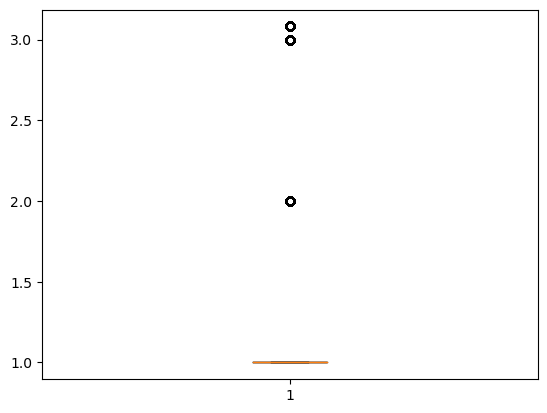

In [79]:
plt.boxplot(df["no_of_trainings"])

In [7]:
#handling age outliers using quantile method
Q3 = df["age"].quantile(0.75)
Q1 = df["age"].quantile(0.25)
IQR = Q3-Q1
upper_limit_age = Q3 + 1.5*IQR
lower_limit_age = Q1 - 1.5*IQR

for i in df["age"].index:
    if df["age"][i] > upper_limit_age:
        df["age"][i]=upper_limit_age
    elif df["age"][i] < lower_limit_age:
        df["age"][i]=lower_limit_age

C:\Users\91809\AppData\Local\Temp\ipykernel_10652\3705693682.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["age"][i]=upper_limit_age


{'whiskers': [<matplotlib.lines.Line2D at 0x2b143f44370>,
 'caps': [<matplotlib.lines.Line2D at 0x2b143f98fa0>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b143f44d00>],
 'medians': [<matplotlib.lines.Line2D at 0x2b143f989a0>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b143f98ee0>],
 'means': []}

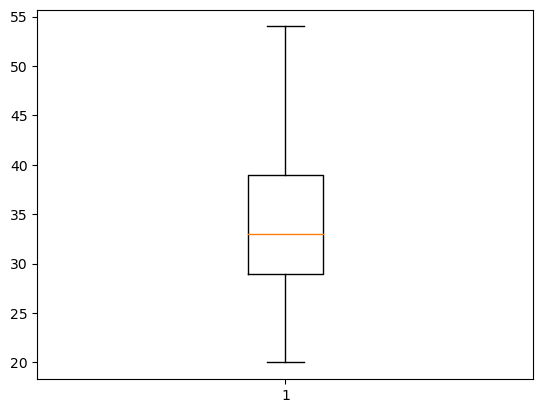

In [84]:
plt.boxplot(df["age"])

In [8]:
#handling outliers in length_of_service using quantile method

Q3 = df["length_of_service"].quantile(0.75)
Q1 = df["length_of_service"].quantile(0.25)
IQR = Q3-Q1
upper_limit_service = Q3 + (1.5*IQR)
lower_limit_service = Q1 - (1.5*IQR)
Q1,Q3,IQR,upper_limit_service,lower_limit_service

#keeping lower limit as zero because length of service can't be zero
#lower_limit_service=0

(3.0, 7.0, 4.0, 13.0, -3.0)

In [9]:
for i in df["length_of_service"].index:
    if df["length_of_service"][i] > upper_limit_service:
        df["length_of_service"][i]=upper_limit_service
    elif df["length_of_service"][i] < lower_limit_service:
        df["length_of_service"][i]=lower_limit_service

C:\Users\91809\AppData\Local\Temp\ipykernel_10652\974323319.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["length_of_service"][i]=upper_limit_service


{'whiskers': [<matplotlib.lines.Line2D at 0x2b143f8e670>,
 'caps': [<matplotlib.lines.Line2D at 0x2b143f8e340>,
 'boxes': [<matplotlib.lines.Line2D at 0x2b143f8e430>],
 'medians': [<matplotlib.lines.Line2D at 0x2b143f7db80>],
 'fliers': [<matplotlib.lines.Line2D at 0x2b143f7d640>],
 'means': []}

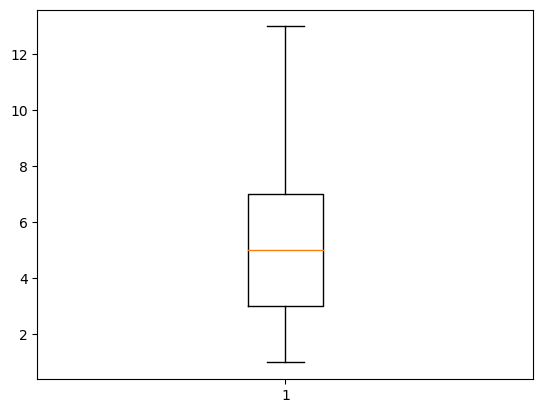

In [92]:
plt.boxplot(df["length_of_service"])

In [ ]:
#Outliers are treated

In [10]:
#encoding gender column
OneHotEncode = OneHotEncoder()
df["gender"] = (OneHotEncode.fit_transform(df[["gender"]])).toarray()

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


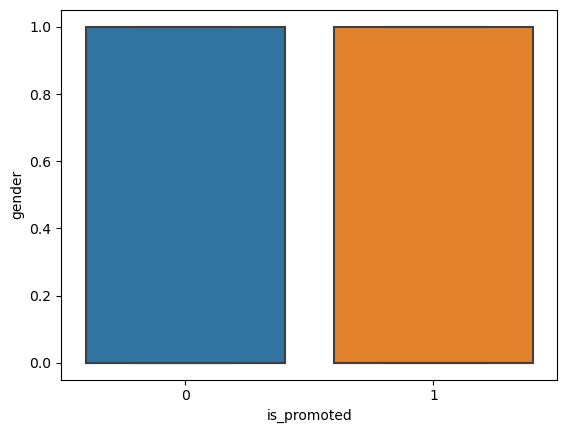

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


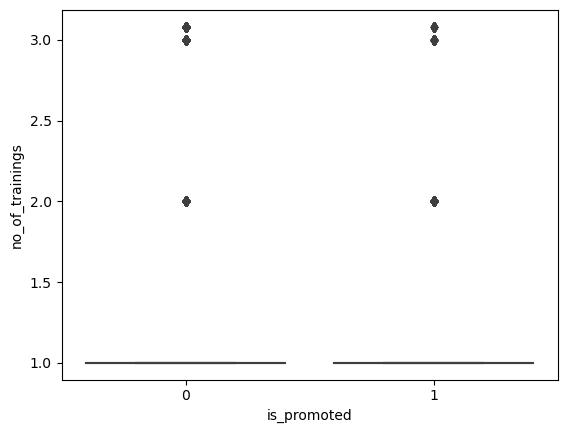

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


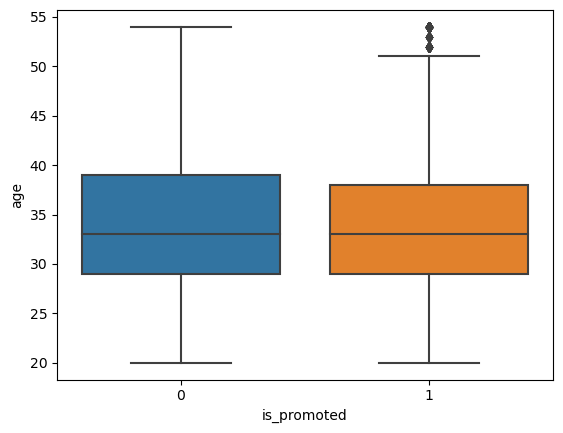

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


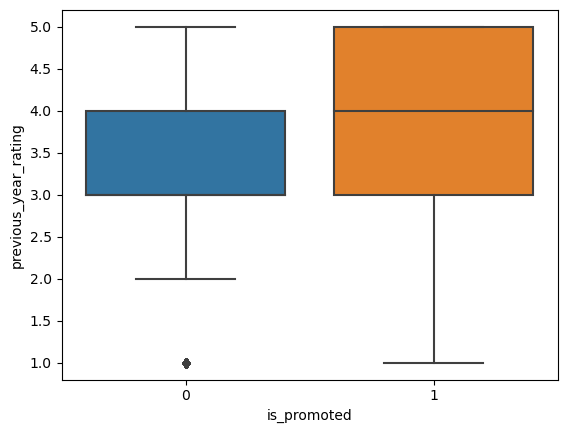

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


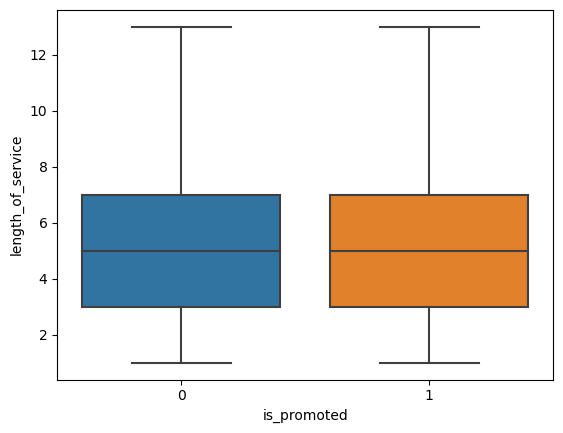

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


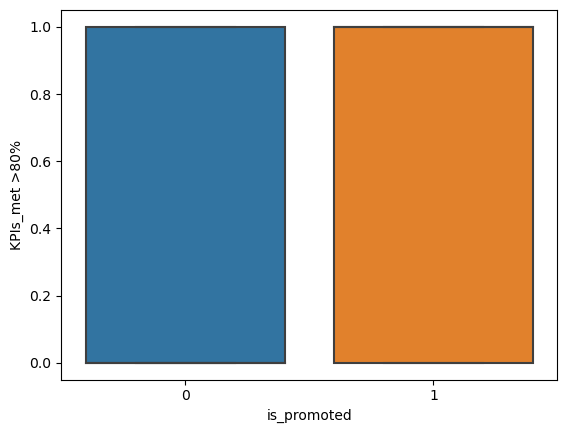

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


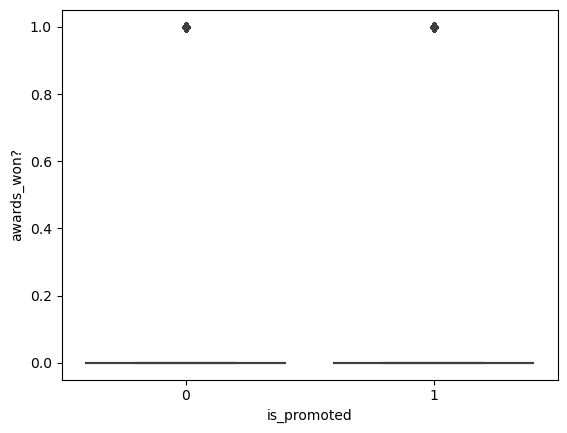

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


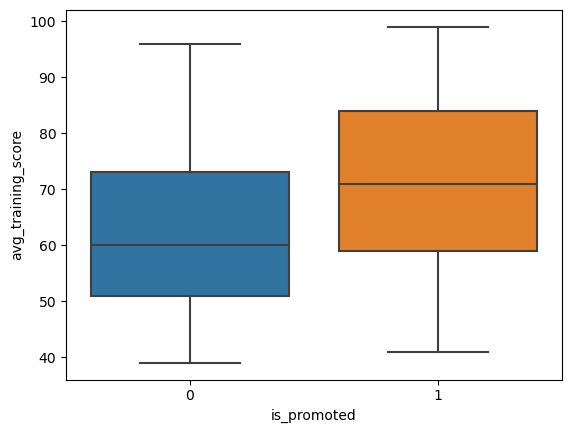

C:\ProgramData\Anaconda3\lib\site-packages\seaborn\_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


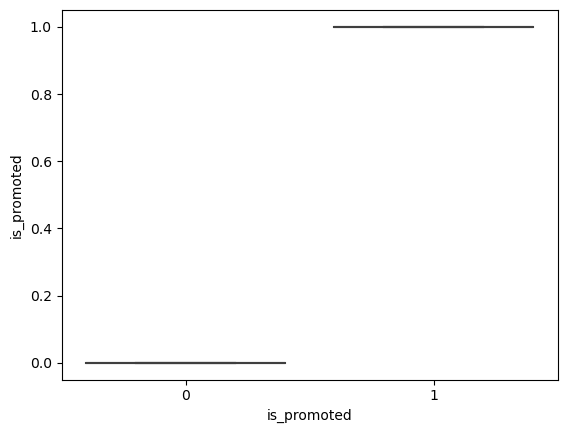

In [198]:
#let's analyze relationship between each column
for i in df.columns:
    sns.boxplot(df["is_promoted"],df[i])
    plt.show()

In [11]:
#let's split the data
X_train,X_test,y_train,y_test = train_test_split(df.iloc[:,0:8],df.iloc[:,-1],test_size=0.2,random_state=41)

In [17]:
#checking target imbalance
print("target Imbalance in train set:")
print("promoted people %: ",(y_train.value_counts()[1]/y_train.value_counts()[0])*100)
print("not promoted people %: ",100-((y_train.value_counts()[1]/y_train.value_counts()[0])*100))
print()
#checking target imbalance
print("target Imbalance in test set:")
print("promoted people %: ",(y_test.value_counts()[1]/y_test.value_counts()[0])*100)
print("not promoted people %: ",100-((y_test.value_counts()[1]/y_test.value_counts()[0])*100))

target Imbalance in train set:
promoted people %:  9.251737971245607
not promoted people %:  90.7482620287544

target Imbalance in test set:
promoted people %:  9.543319676226641
not promoted people %:  90.45668032377336


2023-02-13 20:44:37,076 [21160] INFO     ml_monitor.logging: Starting metrics logging thread...


In [12]:
#scaling data
sc = StandardScaler()
sc.fit(X_train,y_train)
X_train_scaled = sc.transform(X_train)
X_test_scaled = sc.transform(X_test)

In [13]:
#training and evaluating all models with default parameters
LogReg = LogisticRegression()
SGDC = SGDClassifier()
SVClassifier = SVC()
DCT = DecisionTreeClassifier()
BagClass = BaggingClassifier()
VotingClass = VotingClassifier(estimators=[('LogReg',LogisticRegression()),('DCT',DecisionTreeClassifier()),('SVC',SVC()),('RFC',RandomForestClassifier())])
RFC = RandomForestClassifier()
GBC = GradientBoostingClassifier()
GNB = GaussianNB()
MNB = MultinomialNB()
BNB = BernoulliNB()

In [ ]:
LogReg.fit(X_train_scaled,y_train)
SGDC.fit(X_train_scaled,y_train)
SVClassifier.fit(X_train_scaled,y_train)
DCT.fit(X_train_scaled,y_train)
BagClass.fit(X_train_scaled,y_train)
VotingClass.fit(X_train_scaled,y_train)
RFC.fit(X_train_scaled,y_train)
GBC.fit(X_train_scaled,y_train)
GNB.fit(X_train,y_train)
MNB.fit(X_train,y_train)
BNB.fit(X_train,y_train)

In [247]:
y_pred_LogReg = LogReg.predict(X_test_scaled)
y_pred_SGDC = SGDC.predict(X_test_scaled)
y_pred_SVC = SVClassifier.predict(X_test_scaled)
y_pred_DCT = DCT.predict(X_test_scaled)
y_pred_BagClass = BagClass.predict(X_test_scaled)
y_pred_VotingClass = VotingClass.predict(X_test_scaled)
y_pred_RFC = RFC.predict(X_test_scaled)
y_pred_GBC = GBC.predict(X_test_scaled)
y_pred_GNB = GNB.predict(X_test)
y_pred_MNB = MNB.predict(X_test)
y_pred_BNB = BNB.predict(X_test)

C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but GaussianNB was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but MultinomialNB was fitted with feature names
  warnings.warn(
C:\ProgramData\Anaconda3\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but BernoulliNB was fitted with feature names
  warnings.warn(


In [249]:
print(np.round(metrics.accuracy_score(y_test,y_pred_LogReg)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_SGDC)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_SVC)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_DCT)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_BagClass)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_VotingClass)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_RFC)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_GBC)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_GNB)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_MNB)*100,2),"%")
print(np.round(metrics.accuracy_score(y_test,y_pred_BNB)*100,2),"%")

91.31 %
91.31 %
91.71 %
88.14 %
90.43 %
91.71 %
90.91 %
92.28 %
90.83 %
91.24 %
90.82 %


In [258]:
#cross validating
start_time = time.time()
cv_LogReg = np.round(np.mean(cross_val_score(LogReg,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_SGDC = np.round(np.mean(cross_val_score(SGDC,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_SVClassifier = np.round(np.mean(cross_val_score(SVClassifier,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_DCT = np.round(np.mean(cross_val_score(DCT,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_BagClass = np.round(np.mean(cross_val_score(BagClass,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_VotingClass = np.round(np.mean(cross_val_score(VotingClass,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_RFC = np.round(np.mean(cross_val_score(RFC,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_GBC = np.round(np.mean(cross_val_score(GBC,X_train_scaled,y_train,cv=5,n_jobs=-1))*100,2)
cv_GNB = np.round(np.mean(cross_val_score(GNB,X_train,y_train,cv=5,n_jobs=-1))*100,2)
cv_MNB = np.round(np.mean(cross_val_score(MNB,X_train,y_train,cv=5,n_jobs=-1))*100,2)
cv_BNB = np.round(np.mean(cross_val_score(BNB,X_train,y_train,cv=5,n_jobs=-1))*100,2)
print(start_time - time.time())

-54.84827780723572


In [260]:
Algorithm = ["Logistic Regression","SGD Classifier","SV Classifier","DCT","BagClass","VotingClass","RFC","GBC","GNB","MNB","BNB"]
Score_Without_HPT = [
cv_LogReg,
cv_SGDC,
cv_SVClassifier,
cv_DCT,
cv_BagClass,
cv_VotingClass,
cv_RFC,
cv_GBC,
cv_GNB,
cv_MNB,
cv_BNB]
Scores = pd.DataFrame({"Algorith":Algorithm,"Score_W/t_HPT":Score_Without_HPT})
Scores

,Algorith,Score_W/t_HPT
0,Logistic Regression,91.74
1,SGD Classifier,91.53
2,SV Classifier,92.04
3,DCT,87.79
4,BagClass,90.70
5,VotingClass,92.01
6,RFC,91.02
7,GBC,92.64
8,GNB,91.34
9,MNB,91.58


In [14]:
#creating model Pipeline
Imputer = ColumnTransformer([
    ('SimpleImputer',SimpleImputer(strategy="median"),[3])
],remainder='passthrough')
Scaler = ColumnTransformer([
    ('StandardScaler',StandardScaler(),slice(0,7))
],remainder='passthrough')

In [15]:
pipe = Pipeline([
    ('pipe1',Imputer),
    ('Scaler',Scaler),
    ('pipe3',GBC)
]
)

In [17]:
pipe.fit(X_train_scaled,y_train)

Pipeline(steps=[('pipe1',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('SimpleImputer',
                                                  SimpleImputer(strategy='median'),
                                                  [3])])),
                ('Scaler',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StandardScaler',
                                                  StandardScaler(),
                                                  slice(0, 7, None))])),
                ('pipe3', GradientBoostingClassifier())])

In [18]:
Query = np.array([1,1,36,5.0,3,1,1,80],dtype="object").reshape(1,8)
#output = pipe.predict(Query)
#output

In [330]:
#creating model pickle file
pickle.dump(pipe,open('End_to_End_HR_Analytics.pkl','wb'))

In [60]:
#loading and testing saved model
import pickle
test_model = pickle.load(open(r'C:\Users\91809\Downloads\Data Science\Python\Python\Solved_by_own\HR_Analytics_end_to_end\End_to_End_HR_Analytics.pkl','rb'))

2023-02-13 20:48:37,485 [21160] INFO     ml_monitor.logging: Starting metrics logging thread...


In [19]:
y_pred = pipe.predict(Query)
y_pred

array([1], dtype=int64)

In [20]:
import ml_monitor
my_monitor = ml_monitor.Monitor()
my_monitor.start()

2023-02-13 21:31:52,064 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...


In [27]:
#np.random.seed(0)
epochs = 100000
y_train_collector = []
y_pred_collector = []
for i in range(epochs):
    for i in range(10):
        indx = np.random.randint(0,X_train_scaled.shape[0]-1000)
        y_pred = pipe.predict(np.array(X_train_scaled[indx,:]).reshape(1,8))
        y_train_collector.append(y_train.get(indx,default=0))
        y_pred_collector.append(y_pred)
        #print(y_train_collector,y_pred_collector,end="\n")
    my_monitor.monitor("Accuracy",metrics.accuracy_score(y_train_collector,y_pred_collector))
    #print("Accuracy",metrics.accuracy_score(y_train_collector,y_pred_collector))

2023-02-13 22:34:26,807 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:31,819 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:36,833 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:41,850 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:46,863 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:51,877 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:34:56,880 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:35:01,896 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:35:06,914 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:35:11,932 [10652] INFO     ml_monitor.logging: Starting metrics logging thread...
2023-02-13 22:35:16,947 [10652] INFO    

KeyboardInterrupt: 